## Running Topic Modeling with Gensim

Suppose you had several documents and wanted to "discover" the general themes of the corpus. Say you wanted to annotate the documents between 3 different themes, or "topics" as we will refer them to from now on. This is a classic example of using "topic modeling". 

I will illustrate this unsupervised machine learning model with presidential speeches between the two major parties in the U.S. from 1999 to 2016. Due to the training time involved with large sets of documents, I will only use the debates from Iowa and Florida.  

First, let's open the documents with the Pandas module. I will also load all the modules we will need for this tutorial (in case you need <a href=https://anaconda.org/conda-forge/wordcloud>WordCloud</a> or <a href=https://anaconda.org/anaconda/gensim>gensim</a>, see their documentation that explains how to install them).  

In [3]:
import pandas as pd
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from pandas.tseries import offsets
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
%matplotlib inline

debates = pd.read_csv("Presidential_Debates.csv")
debates.head()

,Party,Date,Text
0,Democratic,2016-03-09,PARTICIPANTS:\r\nFormer Secretary of State Hil...
1,Democratic,2016-03-09,MODERATORS:\r\nJorge Ramos (Univision);\r\nMar...
2,Democratic,2016-03-09,RAMOS: [Speaking in Spanish]
3,Democratic,2016-03-09,SALINAS [through translator]: This will be the...
4,Democratic,2016-03-09,RAMOS [through translator]: Here with us tonig...


The documents are loaded in at the speaker/interjection level. This is because we are better able to train the topic model when it assumes a paragraph/statement has it's own distribution of topics. For example, rather than assuming an entire debate has a dominant theme, we can imagine each individual statement has a dominant theme so that the model becomes more dynamic. 

At the end of training the topic model, we will want to aggregate the speeches in some way. As an example, we will aggregate the final speeches by Year and Party. Let's create the Year variable. 

In [4]:
debates["Date"] = pd.to_datetime(debates["Date"])
debates["Year"] = debates["Date"] + offsets.YearEnd()

Now let's preprocess the speeches. We will stem, lowercase, remove stop words, and remove any punctuation and numbers. 

In [5]:
sw = set(stopwords.words("english"))
stemmer = PorterStemmer()

def generate_tokens(text):
    new_text = re.sub("[^A-Za-z]"," ", text)
    tokens = new_text.lower().split()
    tokens = [el for el in tokens if el not in sw]
    tokens = [stemmer.stem(el) for el in tokens]
    return " ".join(tokens).split()

debates["clean_tokens"] = debates["Text"].apply(generate_tokens)

For the gensim LDA model, we will need to feed into the algorithm a gensim.corpora.dictionary. This is something specific to the gensim module, but it essentially just converts a set of documents to numbers/vectors for faster computing. 

In [6]:
debate_tokens = debates.clean_tokens.values
common_dictionary = Dictionary(debate_tokens)
common_corpus = [common_dictionary.doc2bow(text) for text in debate_tokens]

Now, let's estimate the topic model. The most important input is the <b>num_topics</b> variable, which as you might suspect is the number of topics you want the model to "learn". There are some measures like "perplexity" or "coherence" that we can optimize over to choose the best number of topics. However, it is often the case that manual inspection of the topics is the best way to evaluate the model. We also pass in a <b>random_state</b> number so that the initial allocations are random, but we can get the same random numbers back each time we run this model. 

In [7]:
lda = LdaModel(common_corpus, num_topics = 25, 
              id2word = common_dictionary, passes = 5,
              random_state = 1234)

Let's generate graphs for each of the 25 models using the WordCloud module. 

C:\Users\Paul\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


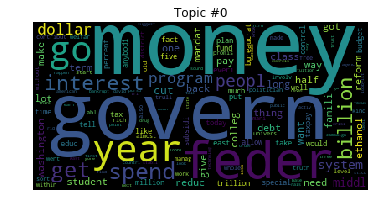

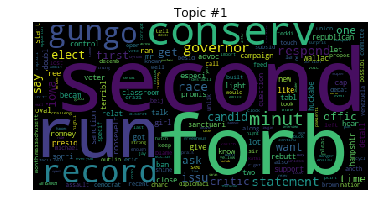

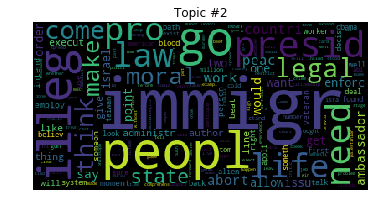

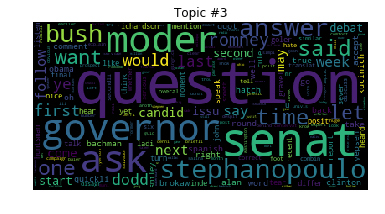

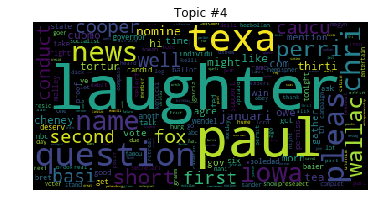

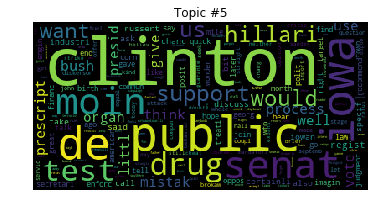

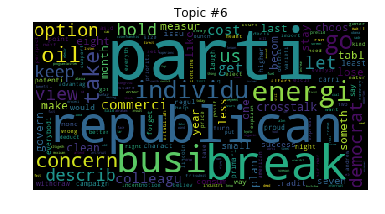

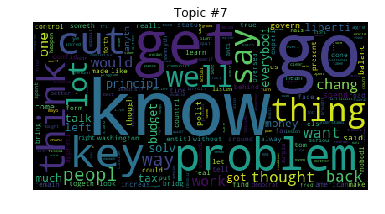

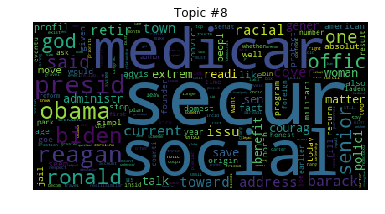

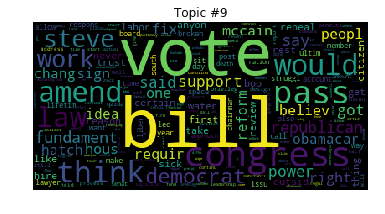

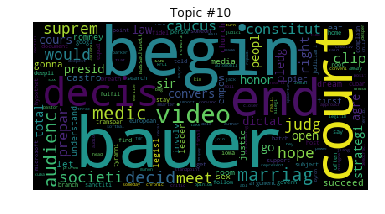

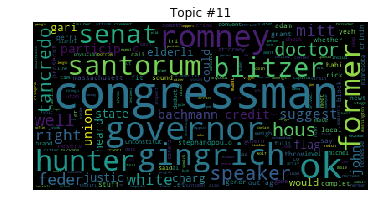

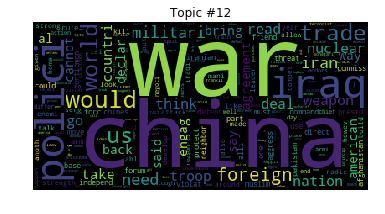

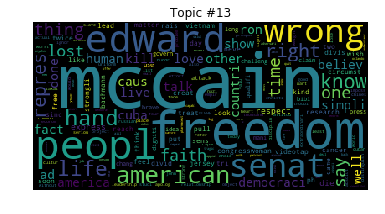

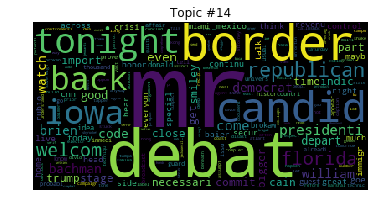

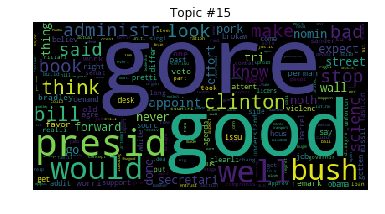

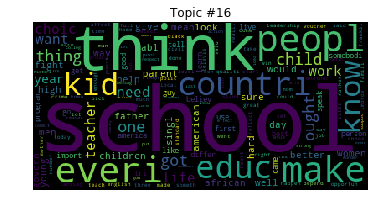

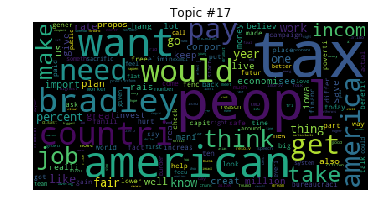

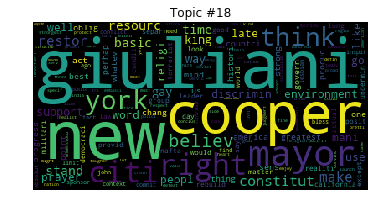

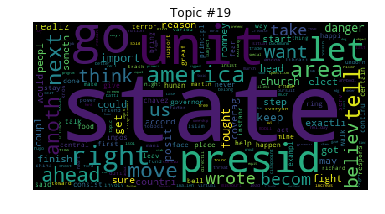

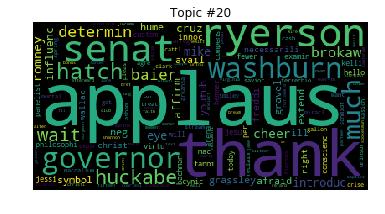

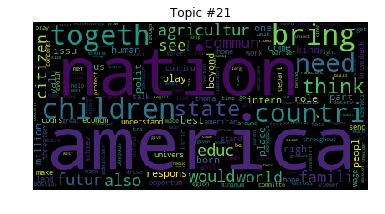

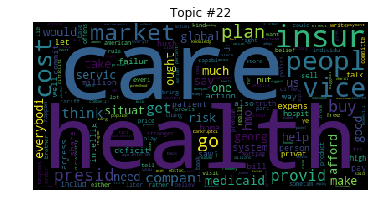

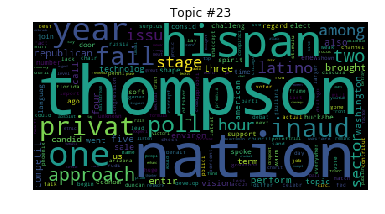

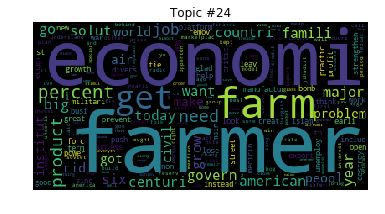

In [8]:
for t in range(lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t,200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.savefig("Topic_"+ str(t)+".png")

It appears that some topics are specific concepts. For example, topic #0 seems to be about federal spending, topic #8 is about social programs, topic #12 is about wars, and topic #22 is about health coverage. 

Now using this topic model, we can evaluate it on an aggregate level. For example, if we want to know how much of the Democrats 2016 debate was about Topic #1, we can aggregate by Party and Year. 

First, let's aggregate the debates by Year and Party. 

In [9]:
debates_agg = debates.groupby(["Party","Year"]).clean_tokens.agg(sum).reset_index()
debates_agg.head()

,Party,Year,clean_tokens
0,Democratic,2000-12-31,"[particip, former, senat, bill, bradley, nj, v..."
1,Democratic,2007-12-31,"[particip, senat, joe, biden, de, senat, hilla..."
2,Democratic,2015-12-31,"[particip, former, secretari, state, hillari, ..."
3,Democratic,2016-12-31,"[particip, former, secretari, state, hillari, ..."
4,Republican,1999-12-31,"[particip, governor, georg, w, bush, tx, gari,..."


Now, let's use the topic model we estimated and predict it on the new set of documents which are the aggregated speeches. 

First, we will need to format these documents in the gensim.corpora.dictionary we need to input into the gensim topic model. 

In [10]:
debate_tokens_agg = debates_agg.clean_tokens.values
common_dictionary_agg = Dictionary(debate_tokens_agg)
common_corpus_agg = [common_dictionary.doc2bow(text) for text in debate_tokens_agg]

Let's predict the topic proportions. 

In [11]:
topic_props = [lda.get_document_topics(doc,minimum_probability=0) for doc in common_corpus_agg]
topic_props_df = pd.DataFrame(topic_props)
topic_props_df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,"(0, 0.05061766)","(1, 0.02810279)","(2, 0.024622547)","(3, 0.034928482)","(4, 0.011998779)","(5, 0.04308793)","(6, 0.018914556)","(7, 0.032827448)","(8, 0.032153297)","(9, 0.022074247)",...,"(15, 0.05526495)","(16, 0.15770693)","(17, 0.10788731)","(18, 0.032410685)","(19, 0.040456206)","(20, 0.026416536)","(21, 0.05089851)","(22, 0.062126722)","(23, 0.015508515)","(24, 0.03152609)"
1,"(0, 0.050200853)","(1, 0.018508289)","(2, 0.05451501)","(3, 0.07698904)","(4, 0.011761926)","(5, 0.04023872)","(6, 0.028455764)","(7, 0.04240782)","(8, 0.039321437)","(9, 0.028527288)",...,"(15, 0.033875637)","(16, 0.0849802)","(17, 0.06456667)","(18, 0.03396161)","(19, 0.032624282)","(20, 0.023773367)","(21, 0.062275738)","(22, 0.043030575)","(23, 0.021262946)","(24, 0.037021466)"
2,"(0, 0.063574396)","(1, 0.030378489)","(2, 0.04132759)","(3, 0.038678043)","(4, 0.01420803)","(5, 0.104941495)","(6, 0.02500675)","(7, 0.03216396)","(8, 0.019044783)","(9, 0.024504991)",...,"(15, 0.0814614)","(16, 0.05801853)","(17, 0.10480492)","(18, 0.028631393)","(19, 0.029615117)","(20, 0.012780352)","(21, 0.055510003)","(22, 0.044794753)","(23, 0.027545456)","(24, 0.044918925)"
3,"(0, 0.058215905)","(1, 0.030819634)","(2, 0.05027238)","(3, 0.046986774)","(4, 0.03925219)","(5, 0.07997274)","(6, 0.030592857)","(7, 0.047237944)","(8, 0.024124058)","(9, 0.024458127)",...,"(15, 0.07255959)","(16, 0.072674766)","(17, 0.09849616)","(18, 0.026565742)","(19, 0.030683324)","(20, 0.023527177)","(21, 0.050969645)","(22, 0.036277972)","(23, 0.021163084)","(24, 0.033218432)"
4,"(0, 0.063810885)","(1, 0.034086)","(2, 0.06522037)","(3, 0.051418465)","(4, 0.012605433)","(5, 0.041691586)","(6, 0.025589388)","(7, 0.06468602)","(8, 0.02653739)","(9, 0.030052409)",...,"(15, 0.030713033)","(16, 0.09343318)","(17, 0.058037292)","(18, 0.020118773)","(19, 0.052399628)","(20, 0.019400753)","(21, 0.053183258)","(22, 0.030458579)","(23, 0.01691832)","(24, 0.0475146)"


This format is a bit weird, so let's remove the 0, 1, 2,..., 25 index for each tuple (ordered pair). We can even feed these back into the aggregated dataframe to have the speeches at the Party Year level as one column.

In [12]:
for each in topic_props_df.columns:
    debates_agg[each] = topic_props_df[each].apply(lambda x: x[1])
debates_agg.head()

,Party,Year,clean_tokens,0,1,2,3,4,5,6,...,15,16,17,18,19,20,21,22,23,24
0,Democratic,2000-12-31,"[particip, former, senat, bill, bradley, nj, v...",0.050618,0.028103,0.024623,0.034928,0.011999,0.043088,0.018915,...,0.055265,0.157707,0.107887,0.032411,0.040456,0.026417,0.050899,0.062127,0.015509,0.031526
1,Democratic,2007-12-31,"[particip, senat, joe, biden, de, senat, hilla...",0.050201,0.018508,0.054515,0.076989,0.011762,0.040239,0.028456,...,0.033876,0.084980,0.064567,0.033962,0.032624,0.023773,0.062276,0.043031,0.021263,0.037021
2,Democratic,2015-12-31,"[particip, former, secretari, state, hillari, ...",0.063574,0.030378,0.041328,0.038678,0.014208,0.104941,0.025007,...,0.081461,0.058019,0.104805,0.028631,0.029615,0.012780,0.055510,0.044795,0.027545,0.044919
3,Democratic,2016-12-31,"[particip, former, secretari, state, hillari, ...",0.058216,0.030820,0.050272,0.046987,0.039252,0.079973,0.030593,...,0.072560,0.072675,0.098496,0.026566,0.030683,0.023527,0.050970,0.036278,0.021163,0.033218
4,Republican,1999-12-31,"[particip, governor, georg, w, bush, tx, gari,...",0.063811,0.034086,0.065220,0.051418,0.012605,0.041692,0.025589,...,0.030713,0.093433,0.058037,0.020119,0.052400,0.019401,0.053183,0.030459,0.016918,0.047515


The interpretation of this dataframe is more clear. The top row shows the Democratic debatesfrom 2000 , and how much of these debates were about Topic #0 (federal spending), Topic #1, etc. Each row's values sum to 1, since these are distributions over topics. 

Lastly, we may be interested in plotting the proportion of these speeches over time. For example, what if we wanted to know how Democratic and Republican debates focused on federal spending (Topic #0) over time? We can do this with the following code, where we plot out Topic #0 over time. 

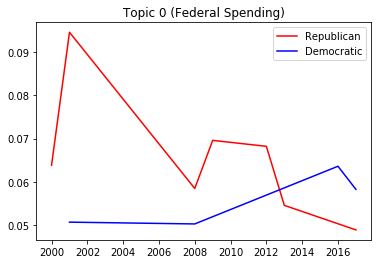

In [13]:
debates_agg.sort_values(["Party","Year"])

republicans = debates_agg[debates_agg.Party=="Republican"]
democratic = debates_agg[debates_agg.Party == "Democratic"]

plt.plot(republicans["Year"], republicans[0], "r-", label="Republican")
plt.plot(democratic["Year"], democratic[0], "b-", label="Democratic")
plt.legend()
plt.title("Topic 0 (Federal Spending)")
plt.show()

## Main Takeaways

    * Preprocessing text for Gensim topic model
    * Estimating Topic Model with gensim
    * Generating word clouds of the term-topic matrices
    * Aggregate a dataframe and query for the document-term proportions